In [1]:
import pandas as pd
import numpy as np
# Load train.csv, test.csv, sample_submission.csv
train_df = pd.read_csv('/kaggle/input/grammar-scoring-engine-data/train.csv')
test_df = pd.read_csv('/kaggle/input/grammar-scoring-engine-data/test.csv')

# Display first few rows of training data
print("Training Data:")
print(train_df.head())

print("\nTesting Data:")
print(test_df.head())


Training Data:
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0

Testing Data:
         filename
0   audio_706.wav
1   audio_800.wav
2    audio_68.wav
3  audio_1267.wav
4   audio_683.wav


In [2]:


import os
print("Files in audios_train:", os.listdir('/kaggle/input/grammar-scoring-engine-data/audios_train/audios_train')[:5])



Files in audios_train: ['audio_90.wav', 'audio_581.wav', 'audio_77.wav', 'audio_817.wav', 'audio_694.wav']


In [3]:
import librosa

# Replace <your-dataset-name> with your actual dataset name
audio_folder_train = '/kaggle/input/grammar-scoring-engine-data/audios_train/audios_train'
audio_folder_test = '/kaggle/input/grammar-scoring-engine-data/audios_test/audios_test'

# Test loading one file from audios_train folder
sample_file = train_df['filename'][0]  # Get the first filename from train.csv
file_path = f"{audio_folder_train}/{sample_file}"  # Construct full path

y, sr = librosa.load(file_path, sr=None)  # Load audio file
print(f"Audio Data Shape: {y.shape}, Sample Rate: {sr}")


Audio Data Shape: (961195,), Sample Rate: 16000


In [4]:
def extract_features(file_name, folder):
    file_path = f"{folder}/{file_name}"
    y, sr = librosa.load(file_path, sr=None)
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
    
    # Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1)
    
    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1)
    
    # Combine features into one array
    return np.concatenate([mfccs, spectral_contrast, chroma])


# Test feature extraction on one file from audios_train folder
features = extract_features(sample_file, audio_folder_train)
print(features)


[-4.85992737e+02  5.01118202e+01  8.83724403e+00  9.50042725e+00
  1.97322249e+00  2.53396702e+00 -6.81178331e+00  1.58786070e+00
 -4.82894659e+00 -3.56634855e+00 -2.68059754e+00 -2.68372083e+00
 -2.37648869e+00  1.66957662e+01  1.43506281e+01  1.73590302e+01
  1.76306172e+01  1.85835737e+01  1.80754630e+01  1.66759818e+01
  4.58705336e-01  4.11259532e-01  4.10763681e-01  3.85070354e-01
  3.66578519e-01  3.65796775e-01  3.86049747e-01  4.31676388e-01
  4.88134086e-01  4.50937092e-01  3.95509005e-01  4.19360310e-01]


In [5]:


import numpy as np

def process_dataset(df, folder):
    feature_list = []
    for file_name in df['filename']:
        features = extract_features(file_name, folder)
        feature_list.append(features)
    return np.array(feature_list)

# Define paths to audios_train and audios_test folders
audio_folder_train = '/kaggle/input/grammar-scoring-engine-data/audios_train/audios_train'
audio_folder_test = '/kaggle/input/grammar-scoring-engine-data/audios_test/audios_test'

X_train = process_dataset(train_df, audio_folder_train)
y_train = train_df['label'].values

X_test = process_dataset(test_df, audio_folder_test)

print(f"Training Features Shape: {X_train.shape}, Training Labels Shape: {y_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")



Training Features Shape: (444, 32), Training Labels Shape: (444,)
Testing Features Shape: (195, 32)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rf_model.fit(X_train_split, y_train_split)

val_predictions = rf_model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_predictions)

print(f"Validation MAE: {val_mae}")




Validation MAE: 0.7914606741573034


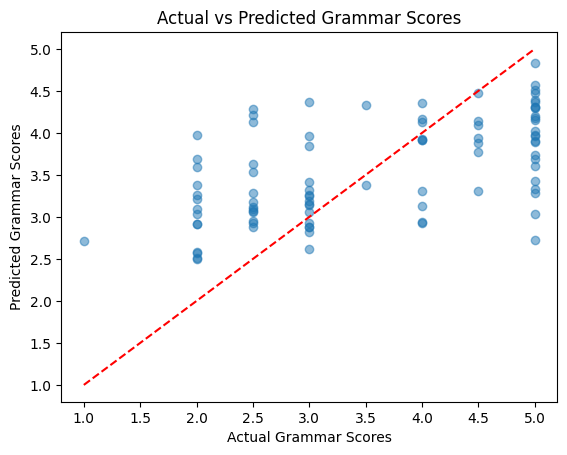

In [9]:
import matplotlib.pyplot as plt
plt.scatter(y_val, val_predictions, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red')  # Reference line
plt.title('Actual vs Predicted Grammar Scores')
plt.xlabel('Actual Grammar Scores')
plt.ylabel('Predicted Grammar Scores')
plt.show()


In [10]:
test_predictions = rf_model.predict(X_test)

test_df['label'] = test_predictions

submission_df = test_df[['filename', 'label']]
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

print("Submission file created!")



Submission file created!


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


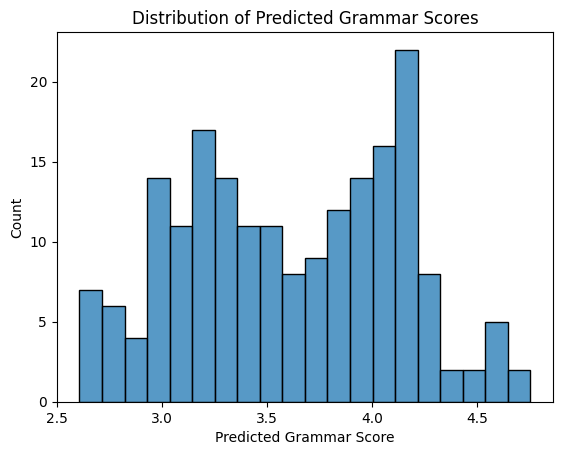

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(test_df['label'], bins=20)
plt.title('Distribution of Predicted Grammar Scores')
plt.xlabel('Predicted Grammar Score')
plt.ylabel('Count')
plt.show()

